In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pyrolite.util.time import Timescale
import cfr

ts = Timescale()

ModuleNotFoundError: No module named 'cartopy'

In [ ]:
# for all csv files in folder dataverse_files, import them into one dataframe. Headers can be different, so need merge import into one dataframe. 
path = r'dataverse_files' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, encoding='latin1', low_memory=False)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=False)

In [ ]:
# filter where column "ROCK NAME" contains "BASALT" and where there is SR87_SR86 data

basalt = frame[frame['ROCK NAME'].str.contains("BASALT", na=False)]
basalt = basalt[basalt['SR87_SR86'].notnull()]

# list "Tectonic Setting" column values
print(basalt['TECTONIC SETTING'].unique())

# filter out "TECTONIC SETTING" values that are not 'SEAMOUNT', 'SUBMARINE RIDGE', 'OCEANIC PLATEAU', 'OCEAN-BASIN FLOOD BASALT'
basalt = basalt[basalt['TECTONIC SETTING'].isin(['SEAMOUNT', 'SUBMARINE RIDGE', 'OCEANIC PLATEAU', 'OCEAN-BASIN FLOOD BASALT'])]

print(basalt['TECTONIC SETTING'].unique())

['INTRAPLATE VOLCANICS' 'OCEAN ISLAND' 'CONVERGENT MARGIN'
 'CONTINENTAL FLOOD BASALT' 'SEAMOUNT' 'RIFT VOLCANICS' 'SUBMARINE RIDGE'
 'OCEANIC PLATEAU' 'COMPLEX VOLCANIC SETTINGS' nan
 'OCEAN-BASIN FLOOD BASALT' 'ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)']
['SEAMOUNT' 'SUBMARINE RIDGE' 'OCEANIC PLATEAU' 'OCEAN-BASIN FLOOD BASALT']


In [ ]:
# make age_basalt where either ["MIN. AGE (YRS.)" and "MAX. AGE (YRS.)"] OR "AGE" is not null
age_basalt = basalt[(basalt['MIN. AGE (YRS.)'].notnull() & basalt['MAX. AGE (YRS.)'].notnull()) | basalt['AGE'].notnull()]

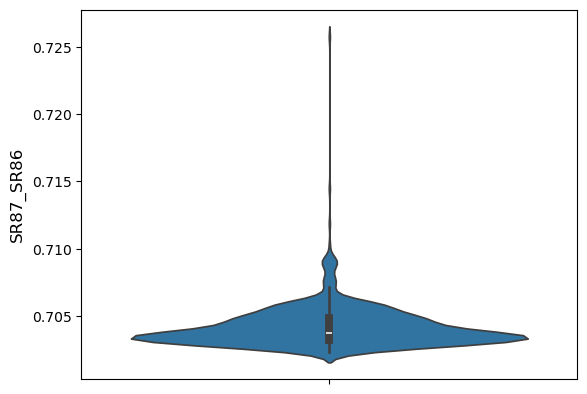

In [ ]:
# do a violin plot of the data
sns.violinplot(y="SR87_SR86", data=age_basalt)
plt.show()

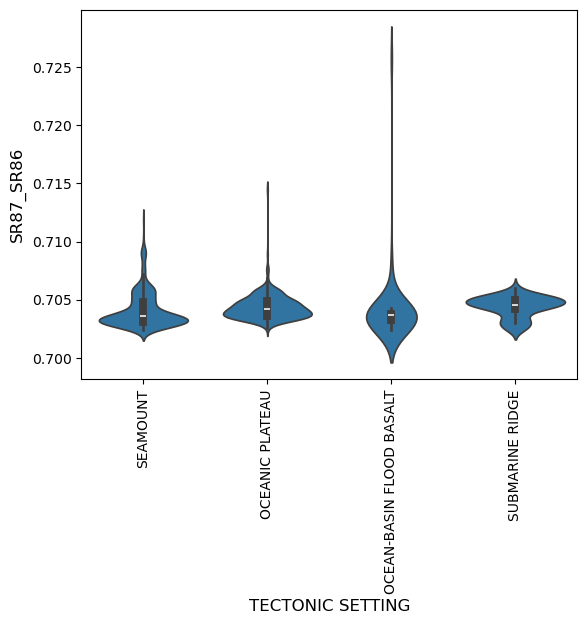

In [ ]:
# vertical x text label
sns.violinplot(x="TECTONIC SETTING", y="SR87_SR86", data=age_basalt)
plt.xticks(rotation=90)
plt.show()

In [ ]:
age = 'DEVONIAN-CARBONIFEROUS'
parts = age.split("-")
a_ages = ts.text2age(parts[0])
b_ages = ts.text2age(parts[1])
min_age = min(min(a_ages), min(b_ages))
max_age = max(max(a_ages), max(b_ages))
float(min_age), float(max_age)

(298.9, 419.2)

In [ ]:
# new column called "numericAGE"
age_basalt.loc[:, 'formattedAge'] = age_basalt['AGE']

# First, create a formatted age column
age_basalt.loc[:, 'formattedAge'] = (
    age_basalt['AGE']  # Use AGE column directly instead of numericAGE
    .str.replace(r"\[.*?\]", "", regex=True)  # Remove square brackets and their contents
    .str.replace(" / ", "-")  # Replace " / " with "-"
    .str.strip()  # Remove leading/trailing whitespace
    .str.replace(" ", "")  # Remove internal spaces
)



# use the pyrolite library to convert the string ages to numeric age minNumAge and maxNumAge. Where there isn't a range (no -) then minNumAge and maxNumAge are the same, otherwise split the range by - and assign the first value to minNumAge and the second value to maxNumAge

# Function to process each age string
def process_age_range(age_str):
    if "-" in age_str:
        parts = age_str.split("-")
        a_ages = ts.text2age(parts[0])
        b_ages = ts.text2age(parts[1])
        min_age = min(min(a_ages), min(b_ages))
        max_age = max(max(a_ages), max(b_ages))
        return float(min_age), float(max_age)
    else:
        ages = ts.text2age(age_str)
        min_age = min(ages)
        max_age = max(ages)
        return float(min_age), float(max_age)

age_basalt.loc[:, 'minNumAge'] = None  # Initialize columns
age_basalt.loc[:, 'maxNumAge'] = None

# Apply the function to each row
age_basalt.loc[:, ['minNumAge', 'maxNumAge']] = age_basalt['formattedAge'].apply(process_age_range).to_list()

/var/folders/h1/f_x47ljd1g779yp8j74wsnkh0000gn/T/ipykernel_10418/666687127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_basalt.loc[:, 'formattedAge'] = age_basalt['AGE']
/var/folders/h1/f_x47ljd1g779yp8j74wsnkh0000gn/T/ipykernel_10418/666687127.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_basalt.loc[:, 'minNumAge'] = None  # Initialize columns
/var/folders/h1/f_x47ljd1g779yp8j74wsnkh0000gn/T/ipykernel_10418/666687127.py:33: SettingWithCopyWarning: 
A value is trying to be set on a cop

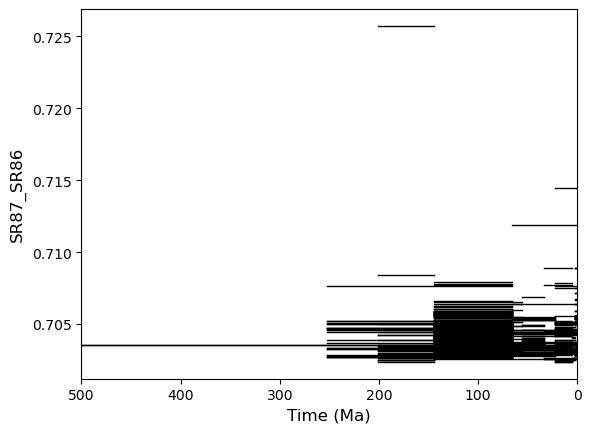

In [ ]:
# plot the data, with x axis is time range and y axis is SR87_SR86, using ax.plot([minNumAge, maxNumAge], [SR87_SR86, SR87_SR86])
#limited to last 500 Ma
# colour is "TECTONIC SETTING"
fig, ax = plt.subplots()

for i, row in age_basalt.iterrows():
    ax.plot([row['minNumAge'], row['maxNumAge']], [row['SR87_SR86'], row['SR87_SR86']], color='k')

plt.xlabel('Time (Ma)')
plt.ylabel('SR87_SR86')

ax.set_xlim(500, 0)
plt.show()

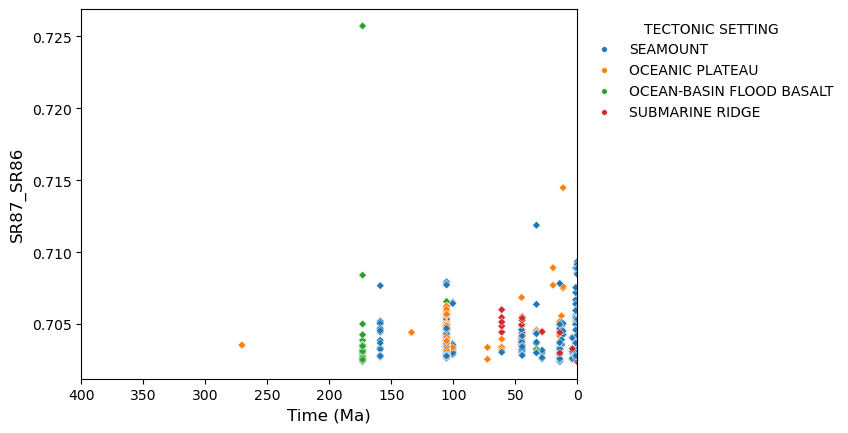

In [ ]:
#plot the midpoint of the age range against SR87_SR86 in last 400 Ma
age_basalt.loc[:, 'midpointAge'] = age_basalt[['minNumAge', 'maxNumAge']].mean(axis=1)

sns.scatterplot(x='midpointAge', y='SR87_SR86', hue='TECTONIC SETTING', data=age_basalt)
plt.xlabel('Time (Ma)')
plt.ylabel('SR87_SR86')
plt.xlim(400, 0)
plt.show()